# CUDA Numba
Numba can be used also as a JIT compiler for functions to be executed in the GPU. Let's have a look. 

In [ ]:
from numba import cuda

# Check whether there exists a CUDA capable GPU in the system. 
print(cuda.is_available())

# Report some information about the available GPUs. 
print(cuda.detect())


# 1. GPU programming with Numba using ufuncs (vectorize)

In [ ]:
from numba import vectorize

# For CPU multicore execution we used target='parallel'
@vectorize(['float64(float64, float64)'], target='cuda')
def add(x, y):
    return x + y


In [ ]:
# allocate and initialize input
import numpy as np
x = np.random.uniform(size=100).astype(np.float64)
y = np.random.uniform(size=100).astype(np.float64)

In [ ]:
%timeit x + y

In [ ]:
%timeit add(x, y)

Wow, the GPU is much slower! That's normal though. There several things to consider when using the GPU to accelerate your code:

* **Input size**: Is the input size large enough to keep the GPU cores busy?
* **Arithmetic intensity**: Is the computation heavy enough, and does it involve math operations?
* **Datatype length**: GPU hardware is usually way less efficient ( 2x to 25x) in running float64 operations than it is in running float32 operations.
* **Data copying**: Maybe we include the time needed to copy the data to the GPU and back to host memory? Is there a way to avoid it?

In [ ]:
# Let's try with an imaginary, compute intensive function
import math
@vectorize(['float32(float32, float32, float32)',
            'float64(float64, float64, float64)'], target='cuda')
def saxpy_trig(x, y, a):
    return math.exp(a * math.sin(x) + math.cos(y))


In [ ]:
x = np.random.uniform(size=10000000).astype(np.float32)
y = np.random.uniform(size=10000000).astype(np.float32)
a = 0.5

In [ ]:
%timeit output = np.exp(a*np.sin(x) + np.cos(y))

In [ ]:
%timeit dev_output = saxpy_trig(x, y, a)

Much better! To remove the data copying overhead, we need to move the data to the device manually. 

In [ ]:
# We can pre-transfer the data to the GPU memory to avoid copying
dev_x = cuda.to_device(x)
dev_y = cuda.to_device(y)
dev_output = cuda.device_array(len(x), dtype=np.float32)
%timeit saxpy_trig(dev_x, dev_y, a, out=dev_output)

In [ ]:
print(dev_output.copy_to_host())

# 2. GPU programming with Numba CUDA kernels

## A 5-min introduction to the CUDA programming model.

1. The GPU (aka **device**) is a hardware accelerator, and lives next to a CPU (aka **host**).
2. The device and the host see **separate memory spaces**. Data allocated in the host are not accessible by the device and vise-versa. 
3. The host issues functions (aka **kernels**) to be executed in the device. 
4. When coding a kernel we have to think in parallel. In fact,  2-levels of nested parallelism:
    1. **Grid** composed of multiple parallel **thread blocks**.
    2. Each thread block composed of parallel **threads**.
5. The **global memory** is accessible by all threads, and is large (\~16 GB) but slow. The **shared memory** is private to each thread block, and small (\~48 ΚB) but fast.

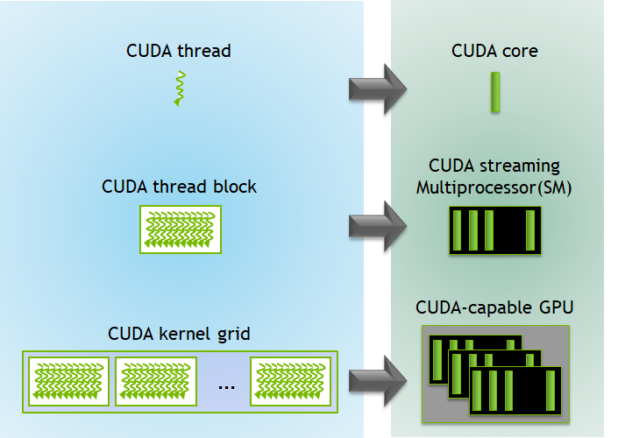

## A Numba CUDA example to accelerate the histogram operation.

In [ ]:
from numba import njit
import math

# Unrolled histogram that runs in the CPU
@njit
def histogram(dt, profile, cut_left, cut_right):
    nbins = profile.shape[0]
    # Calculate the bin width
    inv_bin_width = nbins / (cut_right - cut_left)
    for elem in dt:
        # Find the bin that this particle falls in
        target_bin = np.int32(math.floor((elem-cut_left) * inv_bin_width))
        # Make sure the bin is within the accepted range
        if target_bin >=0 and target_bin < nbins:
            # increase the profile by one
            profile[target_bin] += 1.0

In [ ]:
# initialize the necessary input data

dt = np.random.uniform(size=10000000)
n_slices = 1024
profile = np.zeros(n_slices, dtype=np.float32)
cut_left = 0.05
cut_right = 0.95


In [ ]:
profile *= 0
%time histogram(dt, profile, cut_left, cut_right)

When launching a CUDA kernel, we have to specify two sizes:
1. **Block size**: the number of threads per block. 
2. **Grid size**: the number of thread blocks that will be created in total

These parameters affect the performance of the kernel. Some values that usually work well:
1. Block size: multiple of 32 **and** power of 2 **and** $ ≤ 1024 $ , so: 32, 64, 128, 256, 512, 1024 
2. Grid size: Adjusted so that every thread calculates one output element, i.e. 
$$ grid\_size = int({len(output) + block\_size-1 \over block\_size}) $$ 

In [ ]:
block_size = 1024
grid_size = int((len(dt) + block_size-1) // block_size)
# allocate arrays in the device global memory
dev_dt = cuda.to_device(dt)


In [ ]:
# Each thread is assigned 1 element of the dt array
# we use the thread id to index the dt array

@cuda.jit
def histogram_cuda(dt, profile, cut_left, cut_right):
    # Get the unique thread id    
    tid = cuda.grid(1)
    
    nbins = profile.shape[0]
    
    # Calculate the bin width
    inv_bin_width = nbins / (cut_right - cut_left)

    target_bin = np.int32(math.floor((dt[tid]-cut_left) * inv_bin_width))
    if target_bin >=0 and target_bin < nbins:
        profile[target_bin] += 1

In [ ]:
# Run the kernel
dev_profile = cuda.to_device(np.zeros(n_slices, dtype=np.float32))
histogram_cuda[grid_size, block_size](dev_dt, dev_profile, cut_left, cut_right); cuda.synchronize()
# Kernel launches are asynchronous w.r.t to the host, meaning they return immediately
# to make sure the kernel has finished, we need to use the device synchronization operation 

print('CPU calculated and GPU calculated profiles agree: ', np.allclose(profile, dev_profile.copy_to_host()))
print('CPU calculated profile sum: ', np.sum(profile))
print('GPU calculated profile sum: ', np.sum(dev_profile.copy_to_host()))

## Use of atomic operations.
Something is obviously wrong.

* Multiple threads are simultaneously updating the profile array, leading to a **race condition** and potentially lost updates. 
* To solve this, we will use **atomic** operations, i.e. operations that take place atomically, not interleaved with other threads. 

In [ ]:
@cuda.jit
def histogram_cuda_fixed(dt, profile, cut_left, cut_right):
    # Get the unique thread id    
    tid = cuda.grid(1)
    
    nbins = profile.shape[0]
    
    # Calculate the bin width
    inv_bin_width = nbins / (cut_right - cut_left)

    target_bin = np.int32(math.floor((dt[tid]-cut_left) * inv_bin_width))
    if target_bin >=0 and target_bin < nbins:
        # atomic addition instead of normal addition
        cuda.atomic.add(profile, target_bin, 1)

In [ ]:
dev_profile = cuda.to_device(np.zeros(n_slices, dtype=np.float32))
%time histogram_cuda_fixed[grid_size, block_size](dev_dt, dev_profile, cut_left, cut_right); cuda.synchronize()

## Use of shared memory
As we said above, the shared memory is shared among the threads of each block, it is small and fast, compared to the global memory.

* We should use it for data that is accessed often (or at least 2-3 times). 
* And is not very large in size. 

The profile is a good candidate!

In [ ]:
from numba import int32

@cuda.jit
def histogram_cuda_shmem(dt, profile, cut_left, cut_right):
    # the index of the thread in the block
    tx = cuda.threadIdx.x

    # the index of the thread in the grid
    tid = cuda.grid(1)
    
    nbins = profile.shape[0]
    
    # Calculate the bin width
    inv_bin_width = nbins / (cut_right - cut_left)
    
    # allocate the block private profile in shared memory
    sh_profile = cuda.shared.array(block_size, int32)

    # initialize sh_profile tp zero
    if tx < nbins:
        sh_profile[tx] = 0

    # make sure intialization is done by all threads in block
    # We can't be sure that the shared memory profile will be initialized by all threads
    # before accessed later in line 29.
    # We need a synchronization barrier in between. 
    cuda.syncthreads()

    target_bin = np.int32(math.floor((dt[tid]-cut_left) * inv_bin_width))
    if target_bin >=0 and target_bin < nbins:
        # update the sh_profile, profit from fast shared memory
        cuda.atomic.add(sh_profile, target_bin, 1)
    
    # make sure all threads have completed
    cuda.syncthreads()
    if tx < nbins:
        # accumulate the block private profiles to the global profile
        cuda.atomic.add(profile, tx, sh_profile[tx])

In [ ]:
# first test for correctness
dev_profile = cuda.to_device(np.zeros(n_slices, dtype=np.float32))
histogram_cuda_shmem[grid_size, block_size](dev_dt, dev_profile, cut_left, cut_right); cuda.synchronize()
print(np.allclose(profile, dev_profile.copy_to_host()))

In [ ]:
# Then check the timing
dev_profile = cuda.to_device(np.zeros(n_slices, dtype=np.float32))
%time histogram_cuda_shmem[grid_size, block_size](dev_dt, dev_profile, cut_left, cut_right); cuda.synchronize()

We should normally see an improvement when using the shared memory to store the profile. 


# Summary

* Numba can be also used to GPU accelerate functions
* Can be as simple as setting the`target='cuda'` argument of `@vectorize`
* Or might require a little bit of understanding of the CUDA programming model
* In any case, *not all computations are a good fit for GPU acceleration.*